In [1]:
import pandas as pd
import numpy as np
from statistics import mean, stdev
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# NSL-KDD does not directly include the numeric destination port, but it does include 'service'
head = "/home/dhoogla/PhD/clean-ids-collection"
nslkdd_data = {    
    "nslkdd-train": f"{head}/nsl-kdd/dirty-with-metadata/KDDTrain.parquet",
    "nslkdd-test": f"{head}/nsl-kdd/dirty-with-metadata/KDDTest.parquet",        
}
nslkdd_data['nslkdd'] = [nslkdd_data['nslkdd-train'], nslkdd_data['nslkdd-test']]

In [3]:
tr = pd.read_parquet(nslkdd_data['nslkdd-train'])
tr['subset'] = 'train'
te = pd.read_parquet(nslkdd_data['nslkdd-test'])
te['subset'] = 'test'
        
df = pd.concat(objs=[tr, te], ignore_index=True, copy=False, sort=False)

df = df[['service', 'subset', 'class']]

attack_types = list(df['class'].value_counts().index)
class_idx = df.columns.size -1
df['class'] = df['class'].astype('object')

attacks = df.loc[df['class'] != "normal"].index
df.iloc[attacks, class_idx] = 1.0
df.iloc[df.index.difference(attacks), class_idx] = 0.0
df['class'] = df['class'].astype(dtype=np.float32, copy=False)
print(df['class'].value_counts())

df['service'] = df['service'].astype('category')
df['service'] = df['service'].cat.codes
print(df.shape)

0.0    77054
1.0    71463
Name: class, dtype: int64
(148517, 3)


In [4]:
col = df.columns[-1]
cols = df.columns[:-1]
vc = df[col].value_counts()
n = vc.iloc[-1]
m = vc.iloc[0]
initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
remainder = df.iloc[initial_cut.index, :]    
df = df.drop(index=initial_cut.index)

print(df.shape)

(142926, 3)


In [5]:
df_train = df.loc[df['subset'] == 'train']
df_train.drop(labels=['subset'], axis=1, inplace=True)    
df_train.reset_index(inplace=True, drop=True)
print(df_train.shape)

df_test = df.loc[df['subset'] == 'test']
df_test.drop(labels=['subset'], axis=1, inplace=True)
df_test.reset_index(inplace=True, drop=True)
print(df_test.shape)

df.drop(labels=['subset'], axis=1, inplace=True)

(121105, 2)
(21821, 2)


/tmp/ipykernel_32196/617728654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(labels=['subset'], axis=1, inplace=True)
/tmp/ipykernel_32196/617728654.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(labels=['subset'], axis=1, inplace=True)


In [6]:
gp_train = df_train.groupby('class')
with pd.option_context('display.max_rows', 50):
    print(gp_train.get_group(0.0)['service'].value_counts())
    print(gp_train.get_group(1.0)['service'].value_counts())

24    35267
12     8389
54     6551
20     4625
44     2418
49      911
19      845
60      841
65      564
18      505
14      463
4       219
0       178
47      174
15      170
43      158
63       72
1        55
11       36
64        9
50        7
53        4
62        4
56        4
28        3
61        3
Name: service, dtype: int64
49    20871
14     4089
15     2887
24     2289
20     1876
      ...  
27        2
3         2
22        2
25        1
0         1
Name: service, Length: 66, dtype: int64


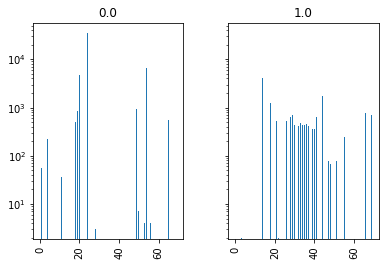

In [7]:
hist_train = df_train.hist(column='service', by='class', bins=256, log=True, sharey=True, sharex=True)

In [8]:
gp_test = df_test.groupby('class')
with pd.option_context('display.max_rows', 50):
    print(gp_test.get_group(0.0)['service'].value_counts())
    print(gp_test.get_group(1.0)['service'].value_counts())

24    6171
12     833
49     784
54     565
20     298
44      63
15      46
18      45
19      44
60      39
14      26
4       18
65      16
0       10
43       9
47       8
63       5
1        4
62       1
61       1
33       1
51       1
Name: service, dtype: int64
49    3922
60    1582
24    1180
47    1011
44     773
      ... 
52       8
65       5
62       5
0        3
12       2
Name: service, Length: 62, dtype: int64


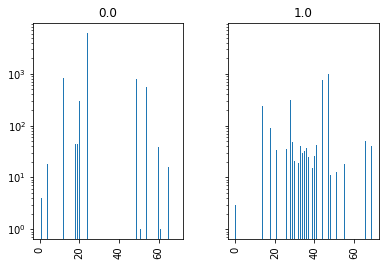

In [9]:
hist_test = df_test.hist(column='service', by='class', bins=256, log=True, sharey=True, sharex=True)

In [10]:
model = RF()
best_param_dict = {
        'bootstrap': True,
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_impurity_decrease': 0.0,
        'min_samples_leaf': 2,
        'n_estimators': 10,
        'max_samples': 0.5,
        'criterion': 'entropy',
        'n_jobs': -1,
        }
model.set_params(**best_param_dict)

RandomForestClassifier(criterion='entropy', max_depth=3, max_samples=0.5,
                       min_samples_leaf=2, n_estimators=10, n_jobs=-1)

In [11]:
X_train = df_train['service']
y_train = df_train['class']
X_test = df_test['service']
y_test = df_test['class']

model.fit(X=X_train.array.reshape(-1,1), y=y_train.array)

RandomForestClassifier(criterion='entropy', max_depth=3, max_samples=0.5,
                       min_samples_leaf=2, n_estimators=10, n_jobs=-1)

In [12]:
intra_outputs = model.predict(X=X_test.array.reshape(-1,1))
intra_acc = accuracy_score(y_true=y_test, y_pred=intra_outputs)
intra_rec = recall_score(y_true=y_test, y_pred=intra_outputs)
intra_pre = precision_score(y_true=y_test, y_pred=intra_outputs)
print(f"NSL-KDD designated => Service")
print(f"Accuracy: {intra_acc:.3f}")
print(f"Recall: {intra_rec:.3f}")
print(f"Precision: {intra_pre:.3f}")

NSL-KDD designated => Service
Accuracy: 0.779
Recall: 0.700
Precision: 0.903
